# Programming Assignment - 4 B Solution

## 4 A

Use the MLLib API of Spark to construct a decision tree for the Breast Cancer Diagnostic data (Data-Link1) (we call it dataset1), available from the UC-Irvine ML repository. Select appropriate parameters to generate only a 3-level deep decision tree. Submit the following.

a.	Your program code.

b.	The choice of parameters and attribute selection metric (Gini index, info gain, etc.) used.

c.	Any assumptions made.

d.	Validation and Train/Test Strategy used.

e.	Decision tree Obtained.

f.	Performance shown by the confusion matrix.

## 4 B

Now use your own code to build a decision tree in Spark. Model your algorithm based on the homework assignment you did for designing the decision tree learning algorithm. Use excactly the same parameter choices as used in (1.) above. 

a.	Submit the same items (1.a-1.f) as for the question above.

b.	Reproduce the results from the 1.e an d 1.f from the previous question and compare with the outputs obtained by your algorithm.


## Solution

b. The choice of parameters:

    Max_depth = 3
    
    Attribute selection metric = Gini Index
    
    
c. Any Assumptions made:

    1. Must use only spark rdd's
    
    2. The class with maximum records out of two classes at leaf nodes is chosen as the label that decision tree predicts.


d. Validation: 

Initially the data is randomly split into test and train. The data is trained on this train dataset to obtain the tree, which is then used to predicted on the test data.
    
    

### Break down of the code with working example:

**Primary Goal in generating decision tree:**

Using spark to get the numbers in the table shown below for every node:

This table shows the number of records that are less than or equal as well as greater than the split value for each feature. Given this it is easier to compute the Information gain for each feature by split value.

![cap3.PNG](cap3.PNG)

**What I need?**

Split_Val for each feature: This is taken as the bin's upper limit.

    Example: there is a bin from value 2 to 4: 4 is the upper limit of the bin and taken as the split value
    
If the number of bins is 5 it has 5 split values which are the upper limits of these bins. 

    Example: 
    
    bin #: lwr - upr    
 
    bin 1: >=2 - =<4 // read as greater than or equal to 2 and less than or equal to 4 
    bin 2: >4  - =<6 // read as greater than 4 and less than or equal to 6
    bin 3: >6  - =<8
    bin 4: >8  - =<10
    bin 5: >10 - =<12
    
    The split values are : 4, 6, 8, 10 and 12 for this feature
    
**Argument - 1: If a record belongs to a bin#x then it is less than or equal to the upper limit of the bins#y, where y >= x. 
And also, greater than the bin#z where z < x**

**How I did it?**

1. Get the min and max values of each bin to compute bin_width and know your upper limits.

2. Replace the real valued features with the bin numbers to which they belong.

3. Use the Argument - 1, to get the numbers in the table shown above:
    
4. After getting the numbers in the table using spark.

5. Collect and transform it into 4-d numpy array (features, bins#, 2 , class_labels). This form will be easy to get the information gain.

6. Get the max value from the array of information gain (features, bins#)

7. Store the corresponding feature, and bin# to compute the Split_Val which is the upper limit of the bin.

8. Split the data into two child the one on left has all the records which have feature's value lesser than the one selected in the above step. And on the right hand side has all the records which have feature's value greater than the one selected in the above step.

9. Now move to the left node and repeat the process of filling the table for this node.

10. Continue this process until you get to the desired depth.

11. The last level of the tree (leaf node) may contain both the classes. So, when interpreting the decision tree replace it with the class of maximum of records.

**How driver function does this?**

The driver function is **get_tree().**

The working of the driver is shown with an example data:

|   ID   |class   |    feature0   |    feature1   |   feature2   |   feature3 |
|--------|--------|---------------|---------------|--------------|------------|
|   1    |   M    |       2       |        3      |       7      |      10    |
|   2    |   B    |       3       |        5      |       6      |       2    |
|   3    |   M    |       5       |        8      |       2      |      12    |
|   4    |   M    |       8       |        6      |       5      |       7    |
|   5    |   B    |       12      |        7      |       12     |       4    |

This data is loaded as a raw_rdd as shown below from a csv file:

raw_rdd -

    ['1,M,2,3,7,10','2,B,3,5,6,2','3,M,5,8,2,12','4,M,8,6,5,7', '5,B,12,7,12,4']

Then the driver function executes the following stages:

#### Stage 1: Find the min and max of each attribute using get_min_max() function.

**Note: This stage will execute a sequence of map - reduce tasks to get min and max of each attribute**

The driver will call the get_min_max() function to get the min and max of the each attribute:

Inputs:

    g_rdd - train data rdd
    
    f_col - number of irrelevant columns like class column and the ID column or the number of feature columns
    
    k - length of f_col
    
Outputs:

    min_f - a dictionary where the feature number is key and min value is the value.
    
    max_f - a dictionary where the feature number is key and max value is the value.
            
we will pass our raw_rdd , f_col: the columns which are not features (array) and k: the length of the f_col array.

Sample Inputs:

    raw_rdd - ['1,M,2,3,7,10','2,B,3,5,6,2','3,M,5,8,2,12','4,M,8,6,5,7', '5,B,12,7,12,4']
    
    f_col - [0, 1]
    
    k - 2

Sample outputs:

    max_f - { 0:12, 1:8, 2:12, 3:12}
    
    min_f - { 0:2,  1:3, 2:2, 3:2}
    
#### Stage 2: Compute the bin width based on the min value, max value, and number of bins desired using get_bin_width() function.

**Note: This stage will not execute a sequence of map - reduce tasks to get bin width of each attribute**

The driver will call the get_bin_width() function to get the bin width for each feature:

Inputs:

    min_f - from get_min_max()
    
    max_f - from get_min_max()
    
    bins - number of bins 
    
Outputs:

    bin_width - a dictionary of bin width for each feature
    
Sample Inputs:

    min_f - { 0:12, 1:8, 2:12, 3:12}
    
    max_f - { 0:2,  1:3, 2:2, 3:2}
    
    bins - 5
    
Sample Outputs:

    Sample calculation: 
    
        min of feature 0: 2, max of feature 0: 12
        
        bin_width of feature 0: (12-2)/5 = 2 

    bin_width - {0:2, 1:1, 2:2, 3:2}
    
#### Stage 3: Get the number of classes in the data and create a dictionary like {'B':0, 'M':1}. This dictionary maps each label to a number. This is done in get_labels() function.

**Note: This stage will execute a sequence of map - reduce tasks to get unique labels in the data**

The function get_labels is called to get the distinct labels in the data by the driver.

Inputs:

    g_rdd - the train data
    
    label_col - the label column
    
Outputs:

    label_dic -  a dictionary where labels are key and a number is a value
  
Sample Inputs:

    g_rdd - ['1,M,2,3,7,10','2,B,3,5,6,2','3,M,5,8,2,12','4,M,8,6,5,7', '5,B,12,7,12,4']

    label_col - 1
    
Sample Outputs:

    label_dic - {'B':0, 'M':1}
    
#### Stage 4:  Clean the data: which removes the ID column , replaces the 0 for class 'B' and 1 for class 'M'. Furthermore, it will transform the real valued features into bins using clean_data() function. 

**Note: This stage will execute a sequence of map - reduce tasks to get clean_rdd **

The driver will call the clean_data() function to get the clean rdd which has no ID column , label replaced with a number and the number of the bin a feature value falls into. 

Inputs:

    g_rdd - training data
    
    label_col - class column
    
    bin_width - dictionary obtained from the get_bin_width() function
    
    labels - dictionary obtained from the get_labels() function
    
    bins - number of bins
    
    min_f - min_f obtained from the get_min_max() function
    
Outputs:

    clean_rdd - each attribute value is replaced with the bin number
    
    
Sample Inputs:

    g_rdd - ['1,M,2,3,7,10','2,B,3,5,6,2','3,M,5,8,2,12','4,M,8,6,5,7', '5,B,12,7,12,4']
    
    label_col - 1
    
    bin_width - {0:2, 1:1, 2:2, 3:2}

    min_f - { 0:2,  1:3, 2:2, 3:2}
    
    labels - {'B':0, 'M':1}
    
    bins - 5
    
**Note: Mapper task will get label_col, bin_width, min_f and labels broadcasted ** 
    
Sample Outputs:

    Sample calculation:
    
    For 1st element in g_rdd: '1,M,2,3,7,10'
    
    0th feature min_f[0] = 2 // min value of 0th feature
    
    bin_width[0] is 2 // bin width of 0th feature 
    
    bins :
    
    bin #: lwr - upr    
 
    bin 1: >=2 - =<4 // read as greater than or equal to 2 and less than or equal to 4 
    bin 2: >4  - =<6 // read as greater than 4 and less than or equal to 6
    bin 3: >6  - =<8
    bin 4: >8  - =<10
    bin 5: >10 - =<12
    
    Now for attribute 0 of value 2 falls in bin number 1.
    
    When you multiply attribute bin_width (2) with bin number(1) and add the min value (2) you get the upper limit of corresponding bin as follows:
    
        upper limit of a feature f of bin# = bin# * bin_width + min
    
        In this case it is : 1*2 + 2 = 4
        
        upper limit of bin 1 is 4.
        
    Repeat the above steps to get bin number for every attribute value in every row.
    
    You get the following:

    [['1,1,1,3,4'],['0,1,2,2,1'],['1,2,5,1,5'],['1,3,3,2,3'],['0,5,4,5,1']]
    
    The comma separated values of each element in rdd are:
    
    1st value : label
    
    2nd value : bin # of attribute 0

    3rd value : bin # of attribute 1
    
    4th value : bin # of attribute 2
    
    5th value : bin # of attribute 3
    
    In this rdd you can see that each attribute is replaced by the bin number in which it falls.
    
    The next step is to convert each element in the above rdd as follows:
    
    [label, (feature#1,bin#,bin#min,bin#max),(feature#2,bin#,bin#min,bin#max)(feature#3,bin#,bin#min,bin#max)]...]
    
    [['1','0,1,1,5','1,1,1,5','2,3,1,5','3,4,1,5'],['0','0,1,1,5','1,2,1,5','2,2,1,5','3,1,1,5'],
     ['1','0,2,1,5','1,5,1,5','2,1,1,5','3,5,1,5'],['1','0,3,1,5','1,3,1,5','2,2,1,5','3,3,1,5'],
     ['0','0,5,1,5','1,4,1,4','2,5,1,5','3,1,1,5']]
     
     label -  label of the record
     
     feature# - feature number 
     
     bin # - bin number to which it belongs to
     
     bin # min - min number of bin which is 1
     
     bin # max -  max number of bin which is 5
     
     This is the rdd that clean_data function returns.
    
#### Stage 5 : Get the numbers  in the table similar to the one shown in the fig 1 using get_num_rec() function.

**Note: This stage will execute a sequence of map - reduce tasks to get num_rec_ar (a numpy array which stores the table info ) **

What is this fig 1 :

![cap3.PNG](cap1.PNG)

**Argument 1:**

The bin number of record 1 and attribute 2 is 3 as in clean_dd:
    
        [ '1', '0,1,1,5', '1,1,1,5', '2,3,1,5', '3,4,1,5'].

Its bin number is less than or equal to the bin numbers: [3,4,5]

also greater than the bin numbers : [1,2]

The same thing can be interpreted as:

The value of the attribute is less than or equal to the upper limit of bins [3,4,5] since it falls in the bin 3 so this record will be counted on the =< side of the above table for these bin numbers 

But its value is also greater than the upper limits of bin numbers : [1,2] so this record will be counted on the > side of the above table for these bin numbers.

Explanation:

upper limits of bins for attribute 3:

bin 1: 4

bin 2: 6

bin 3: 8

bin 4: 10

bin 5: 12

Given record 1 and attribute 2 is in bin 3. Therefore, it is less than or equal to its bin upper limit 8. Also, it is less than or equal to the bins:[4,5] upper limit [10,12] respectively. Similarly, it is greater than the bins:[1,2] upper limit [4,6].

This argument is key in obtaining the numbers in the table.

**How Argument - 1 is used to get the values in the table?**

Explanation with example:

Lets take the record 1, the first element in the clean_rdd:

get_num_rec_mapper1:

    This mapper will take each element in clean_rdd: ['1','0,1,1,5','1,1,1,5','2,3,1,5','3,4,1,5']
    
    converted into: 
    (key=label, value=[(feature#1,bin#,bin#min,bin#max),(feature#2,bin#,bin#min,bin#max)(feature#3,bin#,bin#min,bin#max)])

    ('1', ['0,1,1,5','1,1,1,5','2,3,1,5','3,4,1,5'])
    
flatmMapValues:
    
    ('1', ['0,1,1,5','1,1,1,5','2,3,1,5','3,4,1,5'])

    => [('1','0,1,1,5'),('1','1,1,1,5'),('1','2,3,1,5'),('1','3,4,1,5')]
    
get_num_rec_mapper2:

    This mapper will use the argument 1 as follows:
    
    It will take a elemnt from the above rdd: ('1', '0,1,1,5')
    
    create new list z = []
    
    Iterate "i" (a value) from bin min number to max number:
        
        if bin_number_of_attribute=<i:
        
            add this to z:
                
                'feature#,i,0,class'
                
            ## Here we are making sure that this row is accounted for the case when checked for bin#=<bin_upper_limit_of_i
                
        else :
        
            add this to z:
            
                'feature#,i,1,class'
                
            ## Here we are making sure that this row is accounted for the case when checked for bin#>bin_upper_limit_of_i
                
         
    The z list will look like this for the example element:
    
    ['0,1,0,1','0,2,0,1','0,3,0,1','0,4,0,1','0,5,0,1']
    
    z list for another example element : ('1','2,3,1,5')
    
    ['2,1,1,1','2,2,1,1','2,3,0,1','2,4,0,1','2,5,0,1']
    
    z list is returned
    
flatMap the above rdd:

    ['0,1,0,1','0,2,0,1','0,3,0,1','0,4,0,1','0,5,0,1',...'2,1,1,1','2,2,1,1','2,3,0,1','2,4,0,1','2,5,0,1'...]
    
Map each element in the above rdd as follows:

    [('0,1,0,1',1),('0,2,0,1',1),('0,3,0,1',1).....]
    
    where key is the element of the rdd and the value is 1

reduceByKey and add to get:

    [('0,1,0,0',1),('0,1,0,1',1),('0,1,1,0',1),('0,1,1,1',2)...]
    
    the key signifies the following:
        
        When we break the key by comma:
        
            1st value: feature #
            
            2nd value: bin #
            
            3rd value: 
                       1 indicates all the records whose > bin # 
                       0 indicates all the records whose =< bin#
            
            4th value: class label
            
    That is the element '0,1,0,0' will give the value for the first row and first column in the table shown in fig 1.
    
![cap3.PNG](cap2.PNG)
        
Convert the above rdd into numpy array as num_rec_ar of shape (features, bins, 2, class_labels)

The 2 in the above shape signifies (=< and > bin#)

This numpy array given to stage 6 to get the info gain.

![cap3.PNG](cap4.PNG)

#### Stage 6: Get Info gain of each and every attribute, and bin at test into a numpy array using get_Infogain_ar() function.

Use the numpy array is passed to get_Infogain_ar() function to get the Info gain for each attribute and bin. This Infogain_ar is of shape (features, bins). 

Get the index where the max value for Info gain appears: 

For example if the index is (0,3), it indicates that the feature '0' and bin 3 upper limit value has the maximum info gain.

bin 3 upper limit = 3*bin_width+min_f = 3*2+2 = 8 

So, the test attribute is 3 and value is 8.

**Stage 7a: After getting Info gain numpy array. Find the one which is the maximum value and make corresponding feature as a decision feature with bin*bin_width + min as the value based on the which it will proceed to the next node.**

**Stage 7b: Store this information in the tree_dic dictionary as {Node# : (feature, bin*bin_width+min_f, None, None)}**

**Stage 7c: Store the nodes impurities a.k.a the number of recs per class on the left and right child from the table obatined from the get_num_rec() function as numpy array of shape (features, bins, 2, # of classes).**

**Stage 7d: Split the rdd into two rdd's:**

            l_rdd - this is the rdd which contains all the rows that contain value of the feature selected above =< bin# (bin*bin_width + min).

            r_rdd - this is the rdd which contains all the rows that contain value of the feature selected above > bin# (bin*bin_width + min).
            
The following modifications are important to the rdd after splitting:

Example :

    clean_rdd :
    
    [['1','0,1,1,5','1,1,1,5','2,3,1,5','3,4,1,5'],['0','0,1,1,5','1,2,1,5','2,2,1,5','3,1,1,5'],
     ['1','0,2,1,5','1,5,1,5','2,1,1,5','3,5,1,5'],['1','0,3,1,5','1,3,1,5','2,2,1,5','3,3,1,5'],
     ['0','0,5,1,5','1,4,1,4','2,5,1,5','3,1,1,5']]

If the feature '0' and bin '2' has max Info gain then:

    feature 0 bin# of the 1st row is 1 (=<2) 
    
        ['1','0,1,1,5','1,1,1,5','2,3,1,5','3,4,1,5']
    
            => ['1','0,1,1,2','1,1,1,5','2,3,1,5','3,4,1,5']
     
            Max bin of the feature '0' is changed from the 1 to 2
            
    feature 0 bin# of the 4th row is 3 (>2)
    
        ['1','0,3,1,5','1,3,1,5','2,2,1,5','3,3,1,5']

             => ['1','0,3,3,5','1,3,1,5','2,2,1,5','3,3,1,5']
             
             Min bin of the feature '0' is changed from 1 to 3 

**Stage 7e: Save the above two rdds which will be given to get_num_rec() function. In the next iteration to get the similar table as we got above. These rdd's are stored in the dictionary nodes_rdd[2*i+1: l_rdd, 2*i+2: r_rdd]**

**Stage 7f: Repeat the 7a - 7e on the next nodes rdd in nodes_rdd dictionary until you get the tree of desired depth.**
    
**Stage 8: Use interpret_tree() function to transform the obtained tree_dic to interpretable decision tree for the given max depth.**

**Use predict() to predict the test data.**
    
**Use confusion_mat() to get the confusion matrix.**  

### Import the Data into an rdd

In [1]:
# Import the data into an rdd

raw_rdd = sc.textFile("wdbc.csv")

raw_rdd.take(1)

['842302,M,17.99,10.38,122.8,1001,0.1184,0.2776,0.3001,0.1471,0.2419,0.07871,1.095,0.9053,8.589,153.4,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.6,2019,0.1622,0.6656,0.7119,0.2654,0.4601,0.1189']

### Step -1: Getting max and min of all the columns

The following function will return the column number and its max as well as min value for that column.

Inputs:

    g_rdd - train data rdd
    
    f_col - number of irrelevant columns like class column and the ID column or the number of feature columns
    
    k - length of f_col
    
Outputs:

    min_f - a dictionary where the feature number is key and min value is the value.
    
    max_f - a dictionary where the feature number is key and max value is the value.
    
    Example output:
    
        min_f - {0:2.5} 
        
        max_f - {0:5.0}

In [2]:
# Function to get Max and Min for each column:

# finding Max and Min of each feature using rdd:
def get_min_max(g_rdd, f_col, k):
    def min_max_mapper(x):
    
        x = x.split(",")
        l_f_col = bc_f_col.value
        l_k = bc_k.value
        y = []
        for i in range(0, len(x)):
            if i in l_f_col:
                continue
            else:
                y.append(str(i-k)+"$"+x[i])
        return y

    bc_k = sc.broadcast(k)

    bc_f_col = sc.broadcast(f_col)

    max_f_rdd = g_rdd.map(min_max_mapper)\
                       .flatMap(lambda x: x)\
                       .map(lambda x: (x.split("$")[0],float(x.split("$")[1])))\
                       .reduceByKey(max)


    max_f = max_f_rdd.collect()
    
    max_fv = {}
    
    for i in range(0,len(max_f)):
        max_fv[max_f[i][0]] = max_f[i][1]
    
    min_f_rdd = g_rdd.map(min_max_mapper)\
                   .flatMap(lambda x: x)\
                   .map(lambda x: (x.split("$")[0],float(x.split("$")[1])))\
                   .reduceByKey(min)

    min_f = min_f_rdd.collect()
    
    min_fv = {}
    
    for i in range(0,len(max_f)):
        min_fv[min_f[i][0]] = min_f[i][1]
        
        
    return (min_fv,max_fv)

# # Uncomment the following code to see what this function does
# rem_col = [0]

# label_col = [1]

# f_col = rem_col + label_col

# k = len(rem_col)+len(label_col)
    
# bins = 32

# min_f, max_f = get_min_max(raw_rdd, f_col,k)

# print("min_f:",min_f)

# print("max_f:",max_f)

### Step -2 : Getting the bin width for each feature

This function will return the bin_width for each feature.

Inputs:

    min_f - from get_min_max()
    
    max_f - from get_min_max()
    
    bins - number of bins 
    
Outputs:

    bin_width - a dictionary of bin width for each feature
    
    Example: {0:0.125}

In [3]:
# Get the bin width

# bins = 32

def get_bin_width(min_f, max_f, bins):
    
    bin_width = {}

    for i in range(0, len(max_f)):
    
        bin_width[str(i)]=(max_f[str(i)]-min_f[str(i)])/bins
       
    return bin_width

### Step - 3: Get the class labels in the dataset

This function will make a dictionary of the class labels, where labels are key and a number is a value.

Inputs:

    g_rdd - the train data
    
    label_col - the label column
    
Outputs:

    label_dic -  a dictionary where labels are key and a number is a value
    
    Example: {'B':0, 'M':1}


In [4]:
def get_labels(g_rdd, label_col):
    bc_label_col = sc.broadcast(label_col)
    
    def get_labels_mapper(x):
        x = x.split(",")
        l_label_col = bc_label_col.value[0]
        return str(x[l_label_col])
    
    labels_rdd = g_rdd.map(get_labels_mapper)\
                        .distinct()
    labels = labels_rdd.collect()
    
    labels.sort()
    
    labels_dic = {}
    
    for i in range(0,len(labels)):
        labels_dic[labels[i]] = i

    return labels_dic

# Uncomment the following to see what this function does
# label_col = [1]

# labels = get_labels(raw_rdd, label_col)

# print(labels)


### Step - 4: Getting the binned form of data 

This function will create a new cleaned rdd where each attribute value is replaced with the bin number. This bin number is chose in such a way that when you multiply it with the bin_width and add the min of that attribute you get the upper limit of the bin in which it is present.

For example:

    attribute value = 5
    
    bin_width is 2
    
    bins :
    
    bin 1: 0-2
    bin 2: 2-4
    bin 3: 4-6
    bin 4: 6-8
    bin 5: 8-10
    
    Now 5 falls in bin number 3.
    
    When you multiply attribute bin_width (2) with bin number(3) and add the min value (0) you get the upper limit of corresponding bin as follows:
    
        In this case it is : 3*2 + 0= 6
        
    This information will be further used in the next steps to fill in the data for tabel in fig 4.16.
    
Inputs:

    g_rdd - training data
    
    label_col - class column
    
    bin_width - dictionary obtained from the get_bin_width() function
    
    labels - dictionary obtained from the get_labels() function
    
    bins - number of bins
    
    min_f - min_f obtained from the get_min_max() function
    
Outputs:

    clean_rdd - each attribute value is replaced with the bin number
    
    Example: [['0','0,2,1,32', '1,5,1,32', '2,7,1,32'...],['1','0,3,1,32', '1,6,1,32', '2,7,1,32']]
    
    first column : '0' => class
    
    second column: feature       => 0
                   bin_number    => 2
                   min_bin_number=> 1
                   max_bin_number=> 32
                   
    Similar interpretation for all the other columns
        

In [5]:
from math import ceil, floor

def clean_data(g_rdd, rem_col, label_col, bin_width, labels, bins, min_f):
    k = len(rem_col)+len(label_col)
    bc_rem_col = sc.broadcast(rem_col)
    bc_label_col = sc.broadcast(label_col)
    bc_bin_width = sc.broadcast(bin_width)
    bc_k = sc.broadcast(k)
    bc_labels = sc.broadcast(labels)
    bc_bins = sc.broadcast(bins)
    bc_min_f = sc.broadcast(min_f)
    
    def clean_data_mapper(x):
        
        x = x.split(",")
        l_rem_col = bc_rem_col.value
        l_k = bc_k.value
        l_bin_width = bc_bin_width.value
        l_label_col = bc_label_col.value
        l_labels = bc_labels.value
        l_bins = bc_bins.value
        l_min_f = bc_min_f.value
        y = []
        for i in range(0, len(x)):
            if i in l_rem_col:
                #y.append(x[i])
                continue
            elif i in l_label_col:
                y.append(str(l_labels[x[i]]))
            else:
                z = (float(x[i])-l_min_f[str(i-l_k)])/l_bin_width[str(i-l_k)]
                if floor(z)<z<ceil(z):
                    z = ceil(z)
                if z==0:
                    z = 1
                y.append(str(i-l_k)+","+str(int(z))+","+"1"+","+str(l_bins))
        return y

    clean_rdd = g_rdd.map(clean_data_mapper)
        
    return clean_rdd

# # Uncomment the following and run to see what this function does
# rem_col = [0]

# label_col = [1]

# f_col = rem_col + label_col

# k = len(rem_col)+len(label_col)
    
# bins = 32

# min_f, max_f = get_min_max(f_col,k)
    
# bin_width = get_bin_width(min_f, max_f, bins)
    
# labels = get_labels(label_col)
    
# b=clean_data(raw_rdd, rem_col, label_col, bin_width, labels, bins, min_f)

# b = b.filter(lambda x: x[2].split(",")[2]>"32")

# print(min_f)

# print(max_f)

# print(bin_width)

# print(b.first())

# print(raw_rdd.first())

### Step -5: Getting the numbers to fill the table like shown in the figure.

The numbers are obatained using the logic discussed below:

    In the Step -4 we got the rdd as shown below:
    
        [['0','0,2,1,32', '1,5,1,32', '2,7,1,32'...],['1','0,3,1,32', '1,6,1,32', '2,7,1,32']]
        
        Now each row in rdd is expanded as follows:
        
            ['0','0,2,1,32', '1,5,1,32', '2,7,1,32'...]
            
       =>   ('0', ['0,2,1,32', '1,5,1,32', '2,7,1,32'...])
            
       =>   ['0', '0,2,1,32'], ['0','1,5,1,32',], ['0','2,7,1,32']..
            
       =>   ('0,1,0,0',1), ('0,2,0,0',1), ('0,3,1,0',1), ('0,4,1,0',1)..
            
            In the above key - value pairs the key has the following four parts separated by ",":
            
            ('0,1,0,0',1), ('0,2,0,0',1), ('0,3,1,0',1):
            
            for the current row, column '0' belongs to bin 2, so:
                
                It is greater than the upper limit of 1*bin_width + min=> this is denoted by '0' at the third position. 
                
                It is lesser than the upper limit of 3*bin_width + min=> this is denoted byt '1' at the third poistion.
                
            The fourth position is the class label, in this case it is '0'.
    
    When we reduce by key and add, we get enough information to fill the following table of fig 1:
    
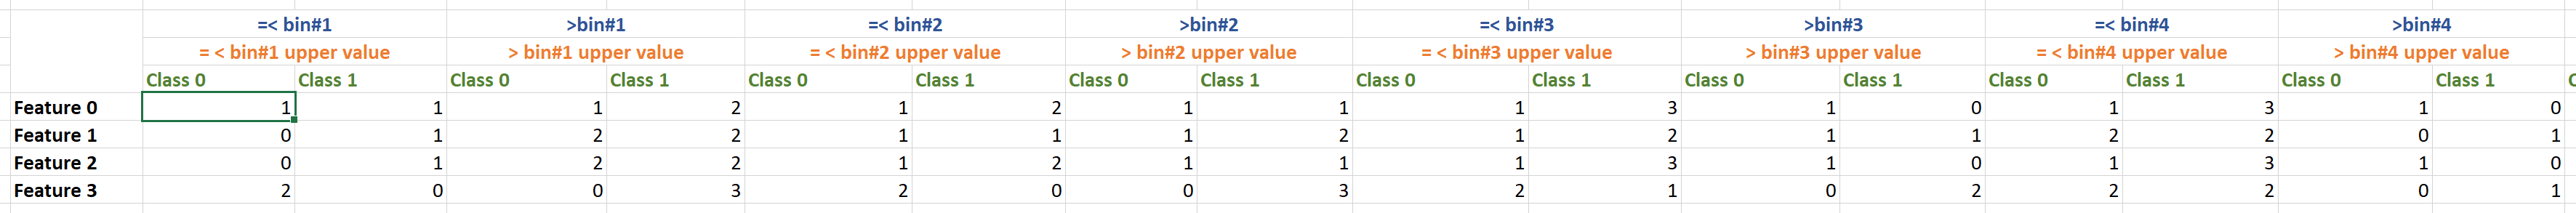

After we obtain the values, we will use 4 dimensional numpy array to visualize the above table.

shape of numpy array: (features, bins, 2, class)

2 denotes the =< and >

Inputs:

    g_rdd - an rdd/data at a node to determine the max info gain
    
    label_col - class label column
    
    bin - number of bins
    
    f_num - the number of features
    
    labels_num - number of classes
    
Output:

    num_rec_ar - a 4-d numpy array realizing the above table of shape (features, bins, 2, class)    
    

In [6]:
from operator import add
import numpy as np

def get_num_rec(g_rdd, label_col, bins, f_num, labels_num):
    
    b_label_col = sc.broadcast(label_col)
    
    def get_num_rec_mapper1(x):
#         z=[]
#         for i in range(0, len(x)):
#             if i!=0:
#                 z.append(x[i])    
        return(x[0],x[1:])

    def get_num_rec_mapper2(x):
        
        z = []
        b = list(map(int,x[1].split(",")))
        x_min = b[2]
        x_max = b[3]
        x_bin = b[1]
        for i in range(x_min,x_max+1):
            if x_bin<=i:
                z.append((str(b[0])+","+str(i)+","+"0"+","+x[0],1))
            else:
                z.append((str(b[0])+","+str(i)+","+"1"+","+x[0],1))
        return z

    r_rdd = g_rdd.map(get_num_rec_mapper1)\
                       .flatMapValues(lambda x:x)\
                       .map(get_num_rec_mapper2)\
                       .flatMap(lambda x:x) \
                       .reduceByKey(add)
                
#    r_rdd = r_rdd.filter(lambda x: x[1][0].split(",")[1]=="1")
    
    r_rdd = r_rdd.sortByKey().collect()
    num_rec_ar = np.zeros((f_num, bins, 2, labels_num))
    
    for k,v in r_rdd:
        k = list(map(int,k.split(",")))
        num_rec_ar[k[0]][(k[1]-1)][k[2]][k[3]] = v
    
    return num_rec_ar

### Step - 6: Compute the Info-gain array of each case

Computation of each possible attribute and corresponding bin number Information gain is done by the following function.

We will use Gini Index to compute the Impurity of the node.

Inputs:

    num_rec_ar - a 4-d numpy array realizing the above table of shape (features, bins, 2, class)  obtained from get_num_rec
    
Outputs:

    num_rec_frac - a numpy 4-d numpy array that sums up the accross the dimension 4 of the num_rec_ar 
    
    current_node_imp - this a array that gives the number of records per class for the current node
    
    Infogain_ar - this array is the required infogain array to find the feature that has more Info-gain 

In [7]:

def get_Infogain_ar(num_rec_ar):
    
    features, bins, dummy, labels = num_rec_ar.shape
        
    num_rec_ar_sum3 = np.sum(num_rec_ar, axis = 3, keepdims=True)
        
    num_rec_frac_ar = num_rec_ar/num_rec_ar_sum3
    
    num_rec_frac_ar[np.isnan(num_rec_frac_ar)] = 0
    
    # Gini Index

    imp_ar = 1 - np.sum(num_rec_frac_ar**2,axis = 3, keepdims=True)
    
    ind = bins-1
    
    current_node_imp = imp_ar[0,ind,0,0]
    
    num_rec_ar_sum23 = np.sum(num_rec_ar_sum3, axis = 2,  keepdims=True)
    
    dum_np_ar = num_rec_ar_sum3[:,:-1,:,:]*imp_ar[:,:-1,:,:]/num_rec_ar_sum23[:,:-1,:,:]
    
    Infogain_ar = current_node_imp - np.sum(dum_np_ar, axis = 2)
    
    return num_rec_frac_ar, current_node_imp, Infogain_ar
    
    

### Step 7-d: This will split the current node rdd into two child rdd's (left child and right child)

This will split based on the feature and the bin number that is has been recognized to have the highest Info gain. 

The following modifications are important to the rdd after splitting:

If the feature '0' and bin '5' has max Info gain then:

        [['0','0,2,1,32', '1,5,1,32', '2,7,1,32'...],['1','0,3,1,32', '1,6,1,32', '2,7,1,32']]

     => [['0','0,2,1,5', '1,5,1,32', '2,7,1,32'...],['1','0,3,1,5', '1,6,1,32', '2,7,1,32']]
     
     Max bin of feature '0' is change to 5
     
If the feature '1' and the bin is '4' has max Info gain:

        [['0','0,2,1,32', '1,5,1,32', '2,7,1,32'...]...]

     => [['0','0,2,1,32', '1,5,5,32', '2,7,1,32'...]...]
     
     Min bin of the feature '1' is change to 4+1 = '5' 

Inputs:

    g_rdd - rdd at that node
    
    rec_dec - recent decision made based on Max Info-gain, it is a tuple containing the (feature, bin number)


In [8]:

def get_lr_rdd(g_rdd, rec_dec):
    
    bc_dec_f = sc.broadcast(rec_dec[0])
    bc_dec_bin = sc.broadcast(rec_dec[1]+1)
    
    
    def get_lr_rdd_mapper(x):
        
        l_dec_f = bc_dec_f.value
        l_dec_bin = bc_dec_bin.value
        
        f_mod = list(map(int,x[l_dec_f+1].split(",")))
        
        if f_mod[1]<=l_dec_bin:
            
            f_mod[3]=l_dec_bin
            
        else:
            
            f_mod[2]=l_dec_bin+1
           
        x[l_dec_f+1]=str(f_mod).replace("[","").replace("]","").replace(" ","")
            
        return x
    
    def get_l_filter(x):
        
        l_dec_f = bc_dec_f.value
        l_dec_bin = bc_dec_bin.value
        
        f_mod = list(map(int,x[l_dec_f+1].split(",")))
        
        if f_mod[1]<=l_dec_bin:
            
            return True 
            
        else:
            
            return False
    
    def get_r_filter(x):
        
        return not get_l_filter(x)
        
    
    l_rdd, r_rdd = (g_rdd.filter(f) for f in (get_l_filter, get_r_filter)) 

    l_rdd = l_rdd.map(get_lr_rdd_mapper)
    
    r_rdd = r_rdd.map(get_lr_rdd_mapper)
    
    return l_rdd, r_rdd
        
        

### Step - 7: Generate the tree:

What this function does?

Call the functions from step-1 to step-6, then do:

    7a. After getting Info gain numpy array. Find the one which is the maximum value and make corresponding feature as a decision feature with bin*bin_width + min as the value based on the which it will proceed to the next node. 

    7b. Store this information in the tree_dic dictionary as [Node# : (feature, bin*bin_width, None, None)

    7c. Store the nodes impurities a.k.a the number of recs per class on the left and right child from the table obatined from the get_num_rec() function as numpy array of shape (features, bins, 2, # of classes).  

    7d. Split the rdd into two rdd's: 

        l_rdd - this is the rdd which contains all the rows that contain value of the feature selected above <= bin*bin_width + min.

        r_rdd - this is the rdd which contains all the rows that contain value of the feature selected above > bin*bin_width + min.

    7e. Save the above two rdds which will be given to get_num_rec() function in the next iteration to get the similar table as we got above. These rdd's are stored in the dictionary nodes_rdd[2*i+1: l_rdd, 2*i+2: r_rdd]

    7f. Repeat the 7a - 7e on the next nodes rdd in nodes_rdd dictionary until you get the tree of desired depth.

Inputs:

    train_rdd - training data
    
    max_depth - depth of the tree
    
    total_col - total number of columns
    
    rem_col - columns that shouldn't be considered like ID column
    
    label_col - column in which class label is present
    
    bins - number of bins
    
Output:

    tree_dic - decision tree in the form of an dictionary, where:
                
                {Node# : (feature_at_test, feature_value, None, None)}
                
    nodes_rec_frac - np_array obtained from the get_Infogain() function
    
    nodes_imp - number of records of each class at each node in the form of a dict as follows:
    
                {Node# : [records_of_class0, records_of_class1]}
                
    labels - labels dictionary of form :
                
                    {'B': 0, 'M': 1}
                    
    bin_width - bin width of each feature
    
    
Tree is visualized as follows:

    Node 0 : root node
    
    Node 1 : left child of root node
    
    Node 2 : right child of root node
    
    Node 3 : left child of (i-1)/2 here i=3 => parent is 2
    
    Node 4 : right child of (i-1)/2 here i=4 => parent is 2
    

In [9]:
def get_tree(train_rdd, max_depth, total_col, rem_col, label_col, bins):
    
    tree_dic = {}

    nodes_rdd ={}
    
    nodes_imp = {}
    
    nodes_rec_frac = {}
    
    f_col = rem_col + label_col

    k = len(rem_col)+len(label_col)
    
    f_num = total_col - k
    
    min_f, max_f = get_min_max(train_rdd, f_col, k)
    
    bin_width = get_bin_width(min_f, max_f, bins)
    
    labels = get_labels(train_rdd, label_col)
    
    clean_rdd = clean_data(train_rdd, rem_col, label_col, bin_width, labels, bins, min_f)
     
    nodes_rdd[0] = clean_rdd
    
    #i = 0
    
    #while max(tree_dic, key=tree_dic.get)==(2**(max_depth)-1):
    
    max_iter = (2**max_depth)-1

    for i in range(0,max_iter): 
        
        if i!=0 and 0 in nodes_rec_frac[i]:
            
            nodes_rec_frac[2*i+1] = nodes_rec_frac[i]
            nodes_rec_frac[2*i+1] = nodes_rec_frac[i]
            
            nodes_rdd[2*i+1] = nodes_rdd[i]
            nodes_rdd[2*i+2] = nodes_rdd[i]
            
            tree_dic[i] = None
            
            nodes_imp[i] = 0 
            
        else:    


            num_rec_ar = get_num_rec(nodes_rdd[i], label_col, bins, f_num, len(labels))

            num_rec_frac_ar, current_node_imp, Infogain_ar = get_Infogain_ar(num_rec_ar)

        #     print(Infogain_ar.shape)

        #     print(Infogain_ar[0])

        #     print(current_node_imp)

        #     print(num_rec_frac_ar.shape)

        #     print(num_rec_frac_ar[0])

        #     print(num_rec_ar[0])

            dec_ind = np.where(Infogain_ar==np.nanmax(Infogain_ar))

            dec_ind = list(a_i[0] for a_i in dec_ind)

        #     print(dec_ind)

            tree_dic[i] = (dec_ind[0], (dec_ind[1]+1)*bin_width[str(dec_ind[0])]+min_f[str(dec_ind[0])], None, None)

            rec_t_dec = (dec_ind[0], dec_ind[1])

            nodes_imp[i] = current_node_imp

            if i==0:
                nodes_rec_frac[i] = num_rec_ar[0,bins-1,0,:].astype(int).tolist()

            nodes_rec_frac[2*i+1] = num_rec_ar[rec_t_dec[0], rec_t_dec[1],0,:].astype(int).tolist()

            nodes_rec_frac[2*i+2] = num_rec_ar[rec_t_dec[0], rec_t_dec[1],1,:].astype(int).tolist()

#             print(rec_t_dec)

#             print(nodes_rec_frac)

#             print(nodes_imp)

    #        print(num_rec_ar[rec_t_dec[0],:,:,:])

            l_rdd , r_rdd = get_lr_rdd(nodes_rdd[i], rec_t_dec)

            nodes_rdd[2*i+1] = l_rdd

            nodes_rdd[2*i+2] = r_rdd

#             print(l_rdd.count())

#             print(r_rdd.count())

#             print(tree_dic)

#         print(nodes_rec_frac)
    
    return tree_dic, nodes_rec_frac, nodes_imp, labels, bin_width


### Calling the get_tree function with appropriate Inputs

The outputs of get_tree function is also printed out.

In [10]:
max_depth = 3

total_col = 32

# irrrelavant columns
rem_col = [0]

# label column
label_col = [1]

bins = 32

k = len(rem_col)+len(label_col)


train_rdd, test_rdd = raw_rdd.randomSplit([0.8, 0.2], seed = 43)

tree_dic, nodes_rec_frac, nodes_imp, labels, bin_width = get_tree(train_rdd, max_depth, total_col, rem_col, label_col, bins)

print("Tree dictionary:\n",tree_dic)

print("\n")

print("nodes_rec_frac:\n",nodes_rec_frac)

print("\n")

print("nodes_imp:\n",nodes_imp)

print("\n")

print("bin_width:\n",bin_width)

print("\n")

print ("labels:\n",labels)            


C:\Users\Varun\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
C:\Users\Varun\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


Tree dictionary:
 {0: (22, 113.15687499999999, None, None), 1: (27, 0.1455, None, None), 2: (21, 20.2275, None, None), 3: (22, 106.88218749999999, None, None), 4: (21, 23.744999999999997, None, None), 5: (7, 0.0691625, None, None), 6: (20, 15.8359375, None, None)}


nodes_rec_frac:
 {0: [281, 180], 1: [275, 29], 2: [6, 151], 3: [268, 9], 4: [7, 20], 5: [5, 6], 6: [1, 145], 7: [258, 4], 8: [10, 5], 9: [6, 1], 10: [1, 19], 11: [5, 0], 12: [0, 6], 13: [1, 0], 14: [0, 145]}


nodes_imp:
 {0: 0.4760000188216693, 1: 0.17258916204986163, 2: 0.07351211002474733, 3: 0.06287062258077136, 4: 0.384087791495199, 5: 0.49586776859504145, 6: 0.013604803903171314}


bin_width:
 {'0': 0.63871875, '1': 0.9240625, '2': 4.4721875, '3': 73.671875, '4': 0.0028771874999999995, '5': 0.010188125, '6': 0.0133375, '7': 0.0062875, '8': 0.005768750000000001, '9': 0.0014309375000000001, '10': 0.075990625, '11': 0.141340625, '12': 0.5591562499999999, '13': 16.7311875, '14': 0.0009192812500000001, '15': 0.004160875, '

### Step - 8: Interpreting the tree 

Call this function to change the tree_dic to a interpretable format as shown below:

    {Node # : (feature_at_test, value, if_feature_value<=value: this class, if_feature_value>value: this class )}

Example:
        
    {..4: (21, 23.744999999999997, 'B', 'M')..}
    
    feature at test at node 4 is 21 and value is 23.7499.
    
    If the test record feature 21 has value =< 23.7499 then the class of the record is 'B'.
    
    Else the test record feature 21 has value > 23.7499 then the class of the record is 'M'.
    
Inputs:

    max_depth - depth of the tree
    
    tree_dic - tree_dic form get_tree() function
    
    nodes_rec_frac - obtained from the get_Infogain() function
    
    labels - obtained form get_tree() function
    
Outputs:

    tree_dic - modified tree_dic as described above
    
    leaf_nodes - leaf_nodes class dictionary

In [11]:

def interpret_tree(max_depth, tree_dic, nodes_rec_frac, labels):
    
    leaf_labels = {}
    
    check = 0
    
    inv_labels = {v:k for k,v in labels.items()}
    
    for i in range(2*max_depth+1, (2**(max_depth+1))-1):
        
            # Selecting leaf nodes class based on max num of records at the leaf nodes
            
            leaf_labels[i] = nodes_rec_frac[i].index(max(nodes_rec_frac[i]))  
            
    for i in range(2*max_depth+1, (2**(max_depth+1))-1,2):
        
        l_label = inv_labels[leaf_labels[i]]
        
        r_label = inv_labels[leaf_labels[i+1]]
        
        if leaf_labels[i] == leaf_labels[i+1]:
            
            father_node = int((i-1)/2)
            
            grandfather_node = int((father_node-1)/2)
            
            if father_node%2!=0:
                
                tree_dic[grandfather_node] = (tree_dic[grandfather_node][0],tree_dic[grandfather_node][1],\
                                           l_label,tree_dic[grandfather_node][3])
            else:
                
                tree_dic[grandfather_node] = (tree_dic[grandfather_node][0],tree_dic[grandfather_node][1],\
                                           tree_dic[grandfather_node][2],r_label)
                
        else:

                father_node = int((i-1)/2)
            
                tree_dic[father_node] = (tree_dic[father_node][0],tree_dic[father_node][1],\
                                           l_label,tree_dic[father_node][3])
                
                tree_dic[father_node] = (tree_dic[father_node][0],tree_dic[father_node][1],\
                                           tree_dic[father_node][2],r_label)

            
            
    return leaf_labels, tree_dic

leaf_labels, tree_dic = interpret_tree(max_depth, tree_dic, nodes_rec_frac, labels)

print("leaf nodes dictionary:\n",leaf_labels)

print( "Tree dictionary:\n",tree_dic)


        


leaf nodes dictionary:
 {7: 0, 8: 0, 9: 0, 10: 1, 11: 0, 12: 1, 13: 0, 14: 1}
Tree dictionary:
 {0: (22, 113.15687499999999, None, None), 1: (27, 0.1455, 'B', None), 2: (21, 20.2275, None, None), 3: (22, 106.88218749999999, None, None), 4: (21, 23.744999999999997, 'B', 'M'), 5: (7, 0.0691625, 'B', 'M'), 6: (20, 15.8359375, 'B', 'M')}


### Step - 9: Prediction function

This function is used to predict the labels of any given row.

Inputs:

    tree_dic - the modified tree_dic
    
    test_rdd - rdd/data upon which it should be tested
    
    max_depth - max depth of the tree
    
    k - number of irrelevant columns other than features like ID and class
    
    label_col - column in which label is present
    
Outputs:

    p_test_rdd - rdd with predicted class is added to class column as follows:
    
        ['ID', 'M,M',...]
        
        where first 'M' is the actual label and second 'M' is the predicted label
        

In [12]:
def predict(tree_dic, test_rdd, max_depth, k, label_col):
    
    bc_max_depth = sc.broadcast(max_depth)    
    bc_tree_dic = sc.broadcast(tree_dic)
    bc_k = sc.broadcast(k)
    bc_label_col = sc.broadcast(label_col)
    
    def predict_mapper(x):
        
        x = x.split(",")
        l_max_depth = bc_max_depth.value
        l_tree_dic = bc_tree_dic.value
        l_k = bc_k.value
        l_label_col = bc_label_col.value
        i = 0
        
        while(i<2**(l_max_depth+1)-1):
            
            feature, val, l_label, r_label = tree_dic[i]
            
            if float(x[feature+l_k]) <= val:
                
                if l_label == None:
                    
                    i = 2*i+1
                    
                else:
                    
                    predicted_label = l_label
                    
                    break
                    
            else:
                
                if r_label == None:
                    
                    i = 2*i+2
                    
                else:
                    
                    predicted_label = r_label
                    
                    break
                    
        x[l_label_col] = x[l_label_col]+","+predicted_label 
        
        return x
    
    p_test_rdd = test_rdd.map(predict_mapper)
    
    return p_test_rdd
    
    
p_test_rdd = predict(tree_dic, test_rdd, max_depth, k, label_col[0])

p_train_rdd = predict(tree_dic, train_rdd, max_depth, k, label_col[0])

print(p_test_rdd.first())
                     

['84300903', 'M,M', '19.69', '21.25', '130', '1203', '0.1096', '0.1599', '0.1974', '0.1279', '0.2069', '0.05999', '0.7456', '0.7869', '4.585', '94.03', '0.00615', '0.04006', '0.03832', '0.02058', '0.0225', '0.004571', '23.57', '25.53', '152.5', '1709', '0.1444', '0.4245', '0.4504', '0.243', '0.3613', '0.08758']


### Step - 10 : Computing confusion matrix

This computation is made easier by adding the predicted class label to the column class as discussed above. Now Mapper just throws that column and reducer will add by key to produce the confusion matrix as shown in the example.

Inputs:

    p_test_rdd - output from the predict()
    
    label_col - label column 
    
Output:

    confusion_mat_rdd - confusion matrix in the form of rdd

In [13]:
def confusion_mat(p_test_rdd, label_col):
    
    bc_label_col = sc.broadcast(label_col)
    
    def confusion_mat_mapper(x):
        
        l_label_col = bc_label_col.value
        
        return(x[l_label_col],1)
    
    confusion_mat_rdd = p_test_rdd.map(confusion_mat_mapper)\
                                  .reduceByKey(add)\
                                  .collect()
    
    return confusion_mat_rdd

confusion_mat_rdd_test = confusion_mat(p_test_rdd, label_col[0])

confusion_mat_rdd_train = confusion_mat(p_train_rdd, label_col[0])

print("Test data confusion matrix:", confusion_mat_rdd_test)

print("Train data confusion matrix:", confusion_mat_rdd_train)
        

Test data confusion matrix: [('M,M', 28), ('M,B', 4), ('B,B', 72), ('B,M', 4)]
Train data confusion matrix: [('M,M', 170), ('M,B', 10), ('B,B', 280), ('B,M', 1)]


### Conclusions:

The validation is assumed to be random sampling. It did yield good results as seen from the confusion matrix above:
    
    The key's first letter indicates the actual class and the next letter is the predicted class
    
    The value is the number of records 

Upon comparison with the 4 A this is little low on performance but from the above we can see that the results are satisfactory.

**What an exciting project!!!**

                                                                                                    Author:
                                                                                                    
                                                                                                    Varun Raj Rayabarapu
                                                                                                    University of Cincinnati